In [1]:
import os
os.chdir('../')

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import os

!nvidia-smi
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Thu Aug 10 12:26:36 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.199.02   Driver Version: 470.199.02   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:1B:00.0 Off |                    0 |
| N/A   47C    P0    71W / 300W |   2905MiB / 80994MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:1C:00.0 Off |                    0 |
| N/A   

### Hyperparams

In [4]:
n_mels = 768
n_outputs = 61
n_frames = 400

In [5]:
from model.model_glowtts_sid import Model
from utils.util import *

device = 'cuda:0'

# Model
model = Model(in_dim=n_mels, enc_hidden_dim=256, out_dim=61, dec_hidden_dim=256)
model = model.to(device)
model.eval()
print('done')

done


In [6]:
!ls -lt /data/scpark/save/lips/train08.09-1/

total 16140704
-rw-rw-r-- 1 scpark scpark     46075  8월 10 12:25 events.out.tfevents.1691588808.GPUSVR11
-rw-rw-r-- 1 scpark scpark 661113053  8월 10 12:00 save_105000
-rw-rw-r-- 1 scpark scpark 661113053  8월 10 10:33 save_100000
-rw-rw-r-- 1 scpark scpark 661110919  8월 10 09:06 save_95000
-rw-rw-r-- 1 scpark scpark 661110919  8월 10 07:40 save_90000
-rw-rw-r-- 1 scpark scpark 661110919  8월 10 06:13 save_85000
-rw-rw-r-- 1 scpark scpark 661110919  8월 10 04:46 save_80000
-rw-rw-r-- 1 scpark scpark 661110919  8월 10 03:19 save_75000
-rw-rw-r-- 1 scpark scpark 661110919  8월 10 01:52 save_70000
-rw-rw-r-- 1 scpark scpark 661110919  8월 10 00:20 save_65000
-rw-rw-r-- 1 scpark scpark 661110919  8월  9 22:47 save_60000
-rw-rw-r-- 1 scpark scpark     36274  8월  9 22:46 events.out.tfevents.1691542949.GPUSVR11
-rw-rw-r-- 1 scpark scpark         0  8월  9 22:46 events.out.tfevents.1691588794.GPUSVR11
-rw-rw-r-- 1 scpark scpark 661110919  8월  9 22:46 save_73247
-rw-rw-r-- 1 scpark scpark 661110919  8월  

In [20]:
path = '/data/scpark/save/lips/train08.09-1/save_80000'
checkpoint = torch.load(path, map_location=torch.device('cpu'))    
model.load_state_dict(checkpoint['model_state_dict'], strict=True)
print('done')

done


In [13]:
!ls -lS /Storage/speech/tts/kaist-audio-book/wav/남1_동화1/

total 732912
-rw-r--r-- 1 guhyun guhyun 1277038  5월 11 19:49 141.spec.pt
-rwxrwxrwx 1 scpark scpark 1199818 11월 13  2019 1181.wav
-rwxrwxrwx 1 scpark scpark 1158070 11월 13  2019 1449.wav
-rw-r--r-- 1 guhyun guhyun 1086254  5월 11 19:49 232.spec.pt
-rw-r--r-- 1 guhyun guhyun 1065710  5월 11 19:49 231.spec.pt
-rw-r--r-- 1 guhyun guhyun  983598  5월 11 19:48 763.spec.pt
-rw-r--r-- 1 guhyun guhyun  971310  5월 11 19:49 140.spec.pt
-rw-r--r-- 1 guhyun guhyun  954929  5월 11 19:48 1801.spec.pt
-rw-r--r-- 1 guhyun guhyun  944625  5월 11 19:48 1512.spec.pt
-rw-r--r-- 1 guhyun guhyun  944625  5월 11 19:33 1805.spec.pt
-rw-r--r-- 1 guhyun guhyun  928238  5월 11 19:48 868.spec.pt
-rw-r--r-- 1 guhyun guhyun  920049  5월 11 19:48 1433.spec.pt
-rw-r--r-- 1 guhyun guhyun  920049  5월 11 19:48 2007.spec.pt
-rw-r--r-- 1 guhyun guhyun  917937  5월 11 19:33 1036.spec.pt
-rw-r--r-- 1 guhyun guhyun  917934  5월 11 19:33 257.spec.pt
-rw-r--r-- 1 guhyun guhyun  913841  5월 11 19:48 1098.spec.pt
-rwxrwxrwx 1 scpark scpark

In [14]:
import fairseq
from torchaudio.transforms import Resample

ckpt_path = "/Storage/speech/pretrained/contentvec/checkpoint_best_legacy_500.pt"
hubert, cfg, task = fairseq.checkpoint_utils.load_model_ensemble_and_task([ckpt_path])
hubert = hubert[0]
hubert = hubert.to(device)
hubert.eval()

def get_hubert_feature(wav):
    with torch.no_grad():
        # (b, t, c)
        wav = torch.Tensor(wav[None, :]).to(device)
        feature = hubert.extract_features(wav, output_layer=12)[0]
        return feature.transpose(1, 2)
print('done')

2023-08-10 12:27:18 | INFO | fairseq.tasks.hubert_pretraining | current directory is /home/scpark/projects/wav2face
2023-08-10 12:27:18 | INFO | fairseq.tasks.hubert_pretraining | HubertPretrainingTask Config {'_name': 'hubert_pretraining', 'data': 'metadata', 'fine_tuning': False, 'labels': ['km'], 'label_dir': 'label', 'label_rate': 50.0, 'sample_rate': 16000, 'normalize': False, 'enable_padding': False, 'max_keep_size': None, 'max_sample_size': 250000, 'min_sample_size': 32000, 'single_target': False, 'random_crop': True, 'pad_audio': False}
2023-08-10 12:27:18 | INFO | fairseq.models.hubert.hubert | HubertModel Config: {'_name': 'hubert', 'label_rate': 50.0, 'extractor_mode': default, 'encoder_layers': 12, 'encoder_embed_dim': 768, 'encoder_ffn_embed_dim': 3072, 'encoder_attention_heads': 12, 'activation_fn': gelu, 'layer_type': transformer, 'dropout': 0.1, 'attention_dropout': 0.1, 'activation_dropout': 0.0, 'encoder_layerdrop': 0.05, 'dropout_input': 0.1, 'dropout_features': 0.1,

done


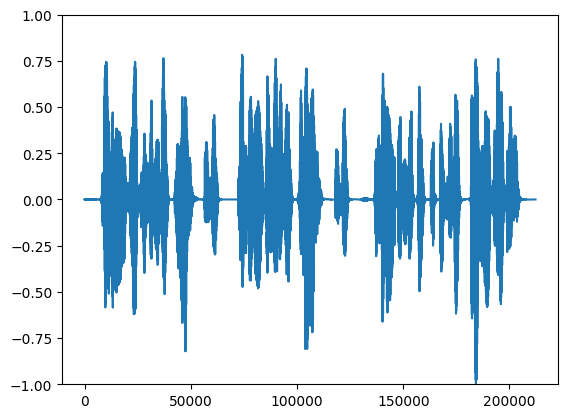

In [21]:
import matplotlib.pyplot as plt
wav_file = '/Storage/speech/tts/kaist-audio-book/wav/남1_동화1/1181.wav'
wav, _ = librosa.load(wav_file, sr=16000, res_type='polyphase')
wav = wav / max(abs(wav))

plt.plot(wav)
plt.ylim([-1, 1])
plt.show()

feature = get_hubert_feature(wav)
feature = F.interpolate(feature, scale_factor=3/5, mode='linear')
sid = torch.Tensor([4]).long().to(device)

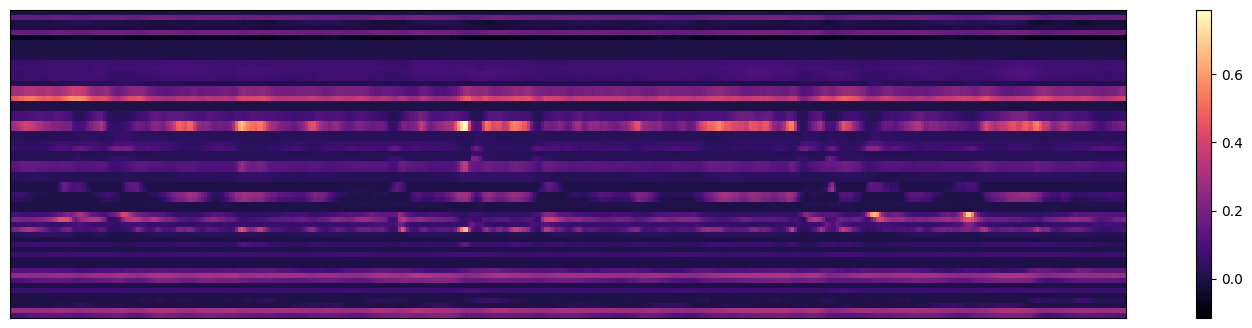

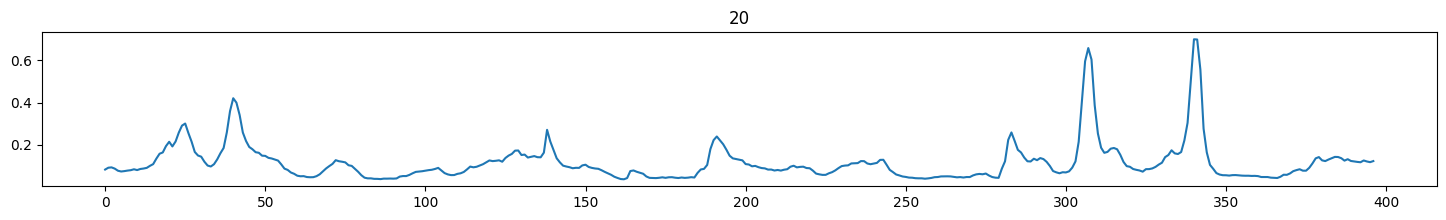

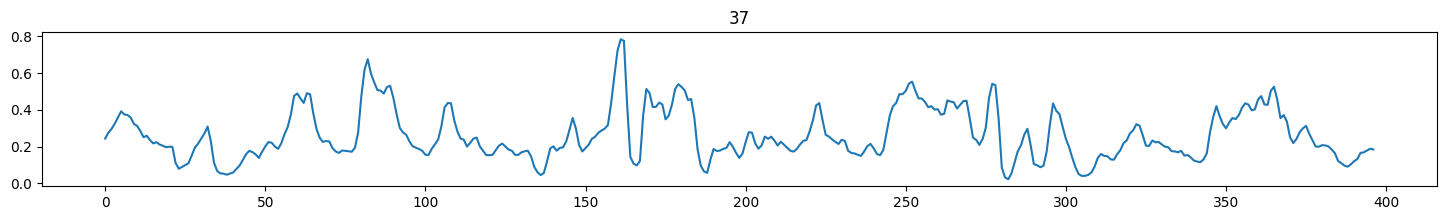

In [22]:
with torch.no_grad():
    y = model.inference(feature, sid=sid, temperature=0.1)
y = y[0].data.cpu().numpy()

import matplotlib.pyplot as plt
import librosa.display

plt.figure(figsize=[18, 4])
librosa.display.specshow(y, cmap='magma')
plt.colorbar()
plt.show()

for i in [20, 37]:
    plt.figure(figsize=[18, 2])
    plt.title(str(i))
    plt.plot(y[i])
    plt.show()
